### T2 관리도 생성 및 해석

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate
from scipy.stats import beta

In [7]:
data = pd.read_csv('data.csv')

In [9]:
def t_square(data, alpha: float = None):
    
    array_data = np.array(data)
    num_sample = len(data)
    
    p = array_data.shape[1]
    
    col_mean = np.mean(array_data, axis=0)  # column mean
    mat_cov = np.cov(array_data.T)  # covariance
    mat_inv_s = np.linalg.inv(mat_cov)  # inverse S
    
    values = []
    for sample in array_data:
        dif = sample - col_mean
        value = mat_inv_s.dot(dif.T).dot(dif)  # T-square
        values.append(value)
    
    CL = (np.power((num_sample -1), 2)) / num_sample
    LCL = 0
    UCL = CL * beta.ppf((1-alpha), p/2, (num_sample - p - 1)/2)
            
    return values, LCL, UCL 

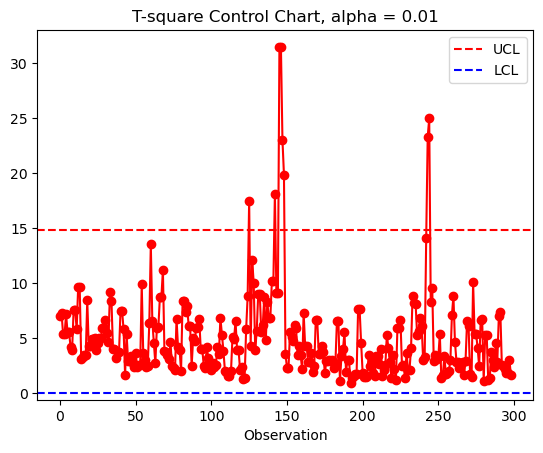

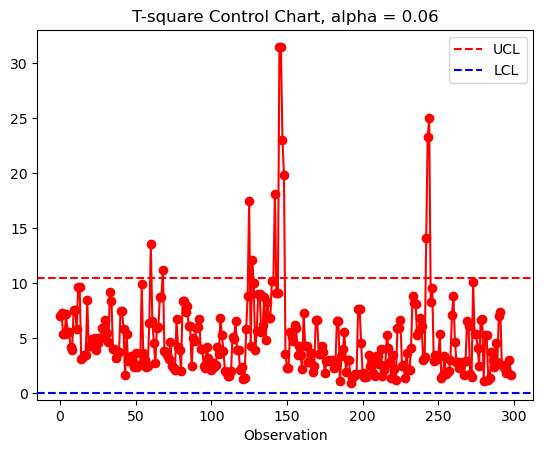

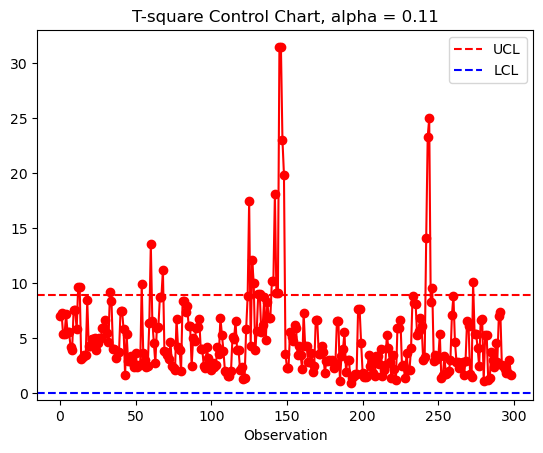

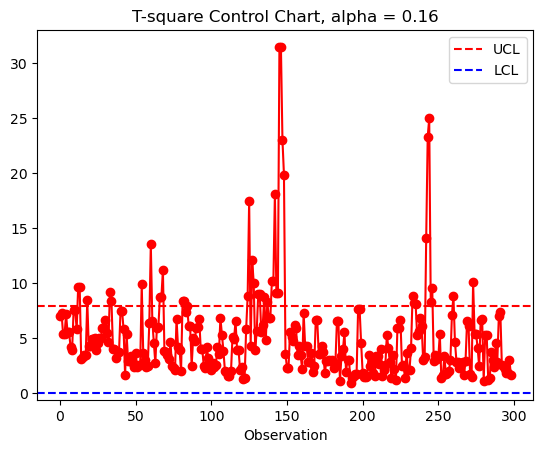

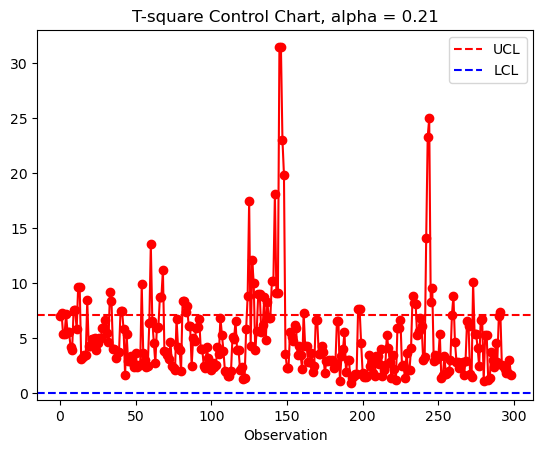

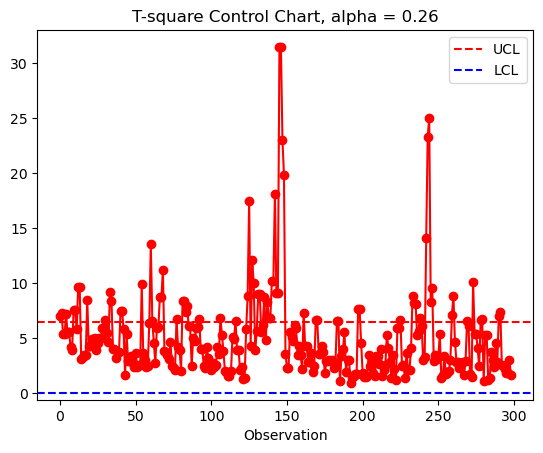

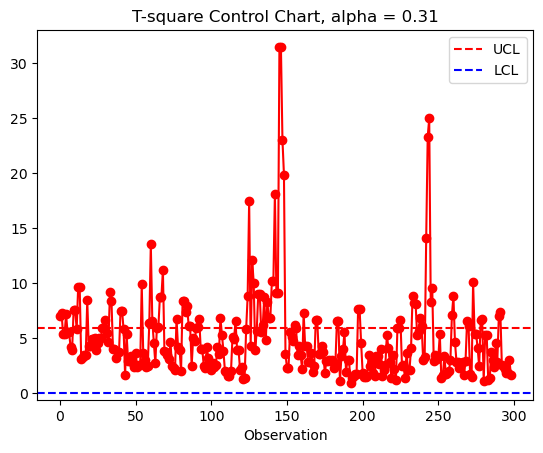

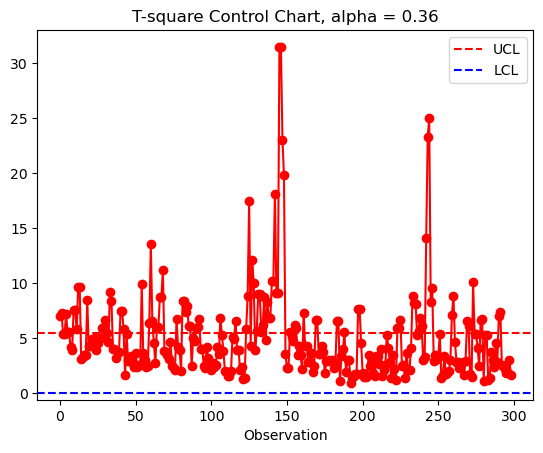

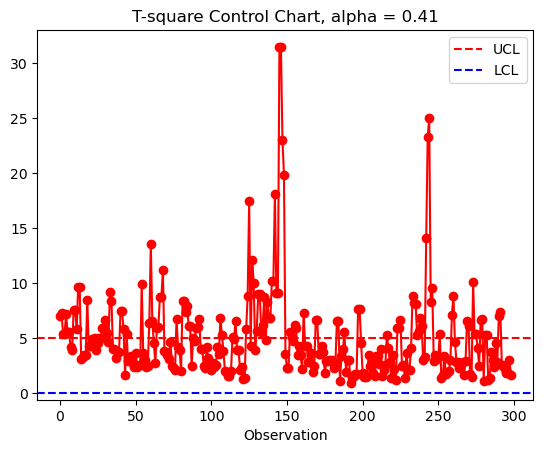

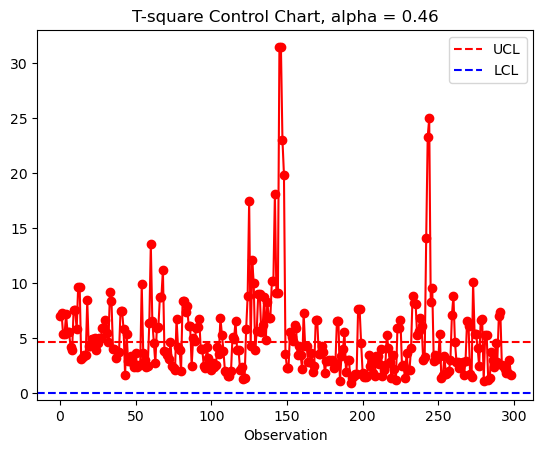

In [11]:
alphas = np.arange(0.01, 0.5, 0.05)

for alpha in alphas:
    values, LCL, UCL = t_square(data, alpha=alpha)
    
    plt.plot(values, marker='o', color='r')
    plt.axhline(UCL, color='r', label='UCL', linestyle='--')
    # plt.axhline(center, color='black', label='Center')
    plt.axhline(LCL, color='b', label='LCL', linestyle='--')
    plt.legend()
    plt.title(f'T-square Control Chart, alpha = {np.round(alpha,3)}')
    plt.xlabel('Observation')
    plt.show()

### F분포와 bootstrap을 이용한 (비)정규분포 데이터에 대한 관리 한계선 비교

In [17]:
import pandas as pd
import numpy as np
from numpy.random import gamma
from numpy.random import multivariate_normal
from scipy.stats import multivariate_t
from scipy.stats import f
import matplotlib.pyplot as plt

In [19]:
def t2_control_limit(data, alpha: float, data_dist_name: str , bs_size: int=100):
    array_data = np.array(data)
    m = len(data) # number of samples   
    p = array_data.shape[1] # number of variables

    x_mean = np.mean(array_data, axis=0) # mean of variables
    cov = np.cov(array_data.T) # covariance
    cov_inv = np.linalg.inv(cov) # inverse S

    t2_values = []
    for sample in array_data:
        dif = sample - x_mean
        t2 = (dif.T).dot(cov_inv).dot(dif)  # T-square
        t2_values.append(t2)
    
    # control limit with f distribution
    CL = (p*(m+1)*(m-1))/(m*(m-p))
    UCL_f = CL * f.ppf(1-alpha, p, m-p)

    # control limit with bootstrap
    quantile_list = []
    for i in range(bs_size):
        samples = np.random.choice(t2_values, size=len(t2_values), replace=True)
        quantile = np.quantile(samples, 1-alpha)
        quantile_list.append(quantile)
    UCL_bs = np.mean(quantile_list)

    # plot control chart
    plt.figure(figsize=(10,5))
    plt.plot(t2_values, color='b')
    plt.axhline(UCL_f, color='r', label='F distribution', linestyle='--')
    plt.axhline(UCL_bs, color='g', label='Bootstrap', linestyle='--')
    plt.legend()
    plt.title(f'T2 Control Chart(F vs Bootstrap), {data_dist_name}, alpha = {alpha}', fontweight='bold')
    plt.ylim((0,100))
    plt.xlabel('Observation')
    plt.ylabel('T2')
    plt.show()

    print('-'*10+' False alarm with F distribution '+'-'*10)
    print(f'Expected false alarm rate: {alpha}')
    print(f'Data false alarm rate: {(t2_values > UCL_f).sum()/len(data)}')

    print('-'*10+' False alarm with Bootstrap '+'-'*10)
    print(f'Expected false alarm rate: {alpha}')
    print(f'Data false alarm rate: {(t2_values > UCL_bs).sum()/len(data)}')

In [21]:
### Parmeters non-normal distribtuion
# Gamma shape parameter small (0.1)
# Log-normal variance big (1.0)
# t degree of freedom small (1)

n_sample = 500

########## Gamma Distribution ##########
# parameter of multivariate gamma distribution
shape_list = [0.1, 0.1, 0.1]
scale_list = [2, 0.7, 1]

# generate data
data_multi_gamma = pd.DataFrame()
for i, (shape, scale) in enumerate(zip(shape_list, scale_list)):
    data = gamma(shape=shape, scale=scale, size=n_sample)
    data_multi_gamma = pd.concat([data_multi_gamma, pd.DataFrame(data, columns=[f'X{i+1}'])], axis=1)

########## Log-normal distribution ##########
# parameter of multivariate normal distribution
mean = [0.0, 2.0, 3.0]
cov = [[1.0, 0.0, 0.0], 
       [0.0, 1.0, 0.0], 
       [0.0, 0.0, 1.0]]

# generate data
data_multi_normal = multivariate_normal(mean=mean, cov=cov, size=n_sample) # log(X)
data_multi_log_normal = np.exp(data_multi_normal) # log(X) -> X

########## t distribution ##########
# parameter multivariate t distribution
# parameter of multivariate normal distribution
loc = [1.0, 2.0, 3.0]
df = 1

# generate data
data_multi_t = multivariate_t(loc=loc, df=df).rvs(size=n_sample)

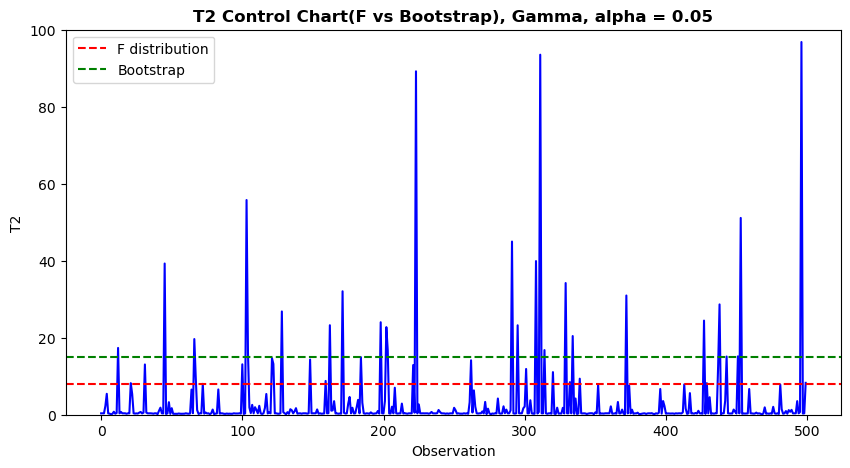

---------- False alarm with F distribution ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.09
---------- False alarm with Bootstrap ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.052


In [24]:
# Gamma distribution T2 control chart
alpha = 0.05
t2_control_limit(data=data_multi_gamma, alpha=alpha, data_dist_name='Gamma')

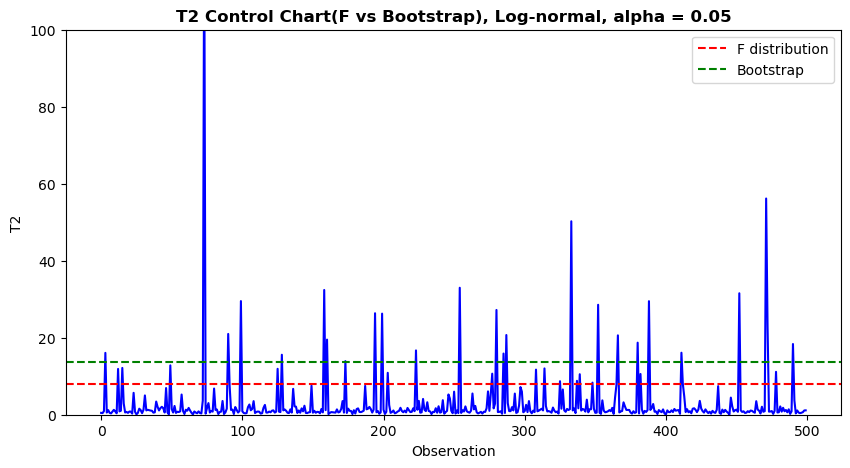

---------- False alarm with F distribution ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.08
---------- False alarm with Bootstrap ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.05


In [26]:
# Log-normal distribution T2 control chart
alpha = 0.05
t2_control_limit(data=data_multi_log_normal, alpha=alpha, data_dist_name='Log-normal')

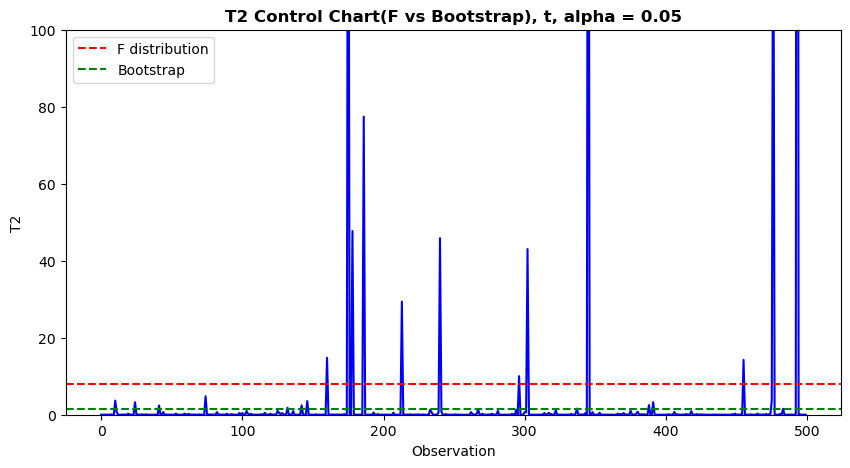

---------- False alarm with F distribution ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.024
---------- False alarm with Bootstrap ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.048


In [28]:
# t distribution T2 control chart
alpha = 0.05
t2_control_limit(data=data_multi_t, alpha=alpha, data_dist_name='t')

In [30]:
### Parmeters similar to normal distribtuion
# Gamma shape parameter big (10)
# Log-normal variance small (0.01)
# t degree of freedom big (30)

n_sample = 500

########## Gamma Distribution ##########
# parameter of multivariate gamma distribution
shape_list = [10.0, 10.0, 10.0]
scale_list = [2, 0.7, 1]

# generate data
data_multi_gamma = pd.DataFrame()
for i, (shape, scale) in enumerate(zip(shape_list, scale_list)):
    data = gamma(shape=shape, scale=scale, size=n_sample)
    data_multi_gamma = pd.concat([data_multi_gamma, pd.DataFrame(data, columns=[f'X{i+1}'])], axis=1)

########## Log-normal distribution ##########
# parameter of multivariate normal distribution
mean = [0.0, 2.0, 3.0]
cov = [[0.01, 0.0, 0.0], 
       [0.0, 0.01, 0.0], 
       [0.0, 0.0, 0.01]]

# generate data
data_multi_normal = multivariate_normal(mean=mean, cov=cov, size=n_sample) # log(X)
data_multi_log_normal = np.exp(data_multi_normal) # log(X) -> X

########## t distribution ##########
# parameter multivariate t distribution
# parameter of multivariate normal distribution
loc = [1.0, 2.0, 3.0]
df = 30

# generate data
data_multi_t = multivariate_t(loc=loc, df=df).rvs(size=n_sample)

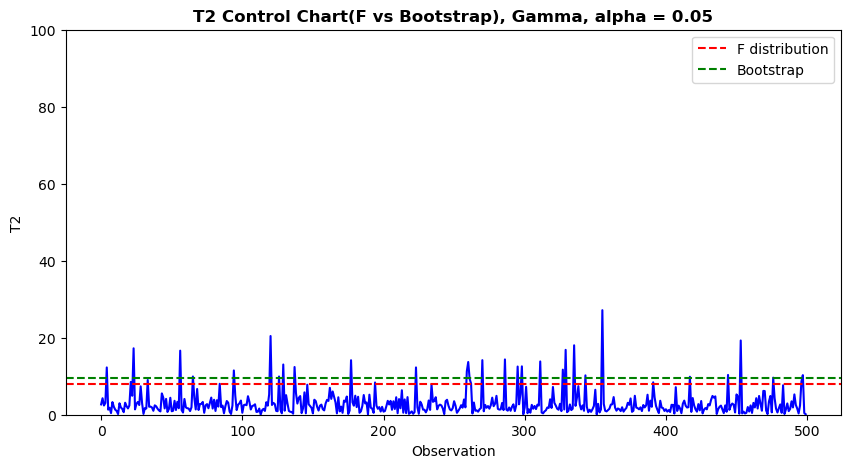

---------- False alarm with F distribution ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.072
---------- False alarm with Bootstrap ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.054


In [32]:
# Gamma distribution T2 control chart
alpha = 0.05
t2_control_limit(data=data_multi_gamma, alpha=alpha, data_dist_name='Gamma')

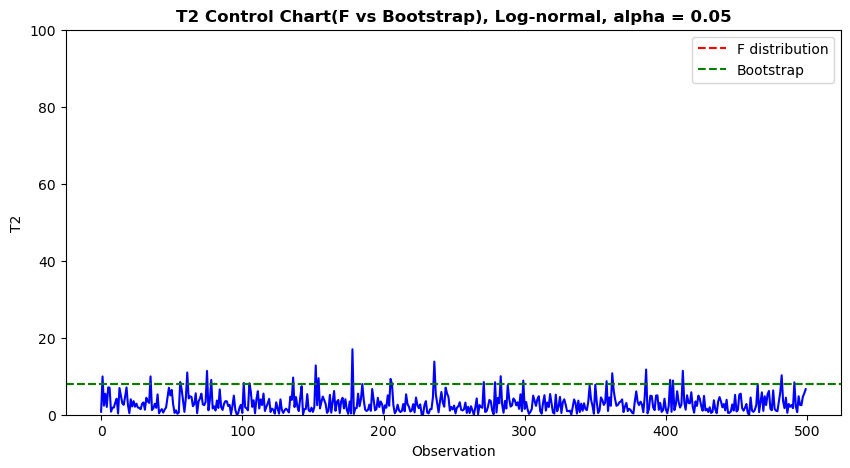

---------- False alarm with F distribution ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.058
---------- False alarm with Bootstrap ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.052


In [35]:
# Log-normal distribution T2 control chart
alpha = 0.05
t2_control_limit(data=data_multi_log_normal, alpha=alpha, data_dist_name='Log-normal')

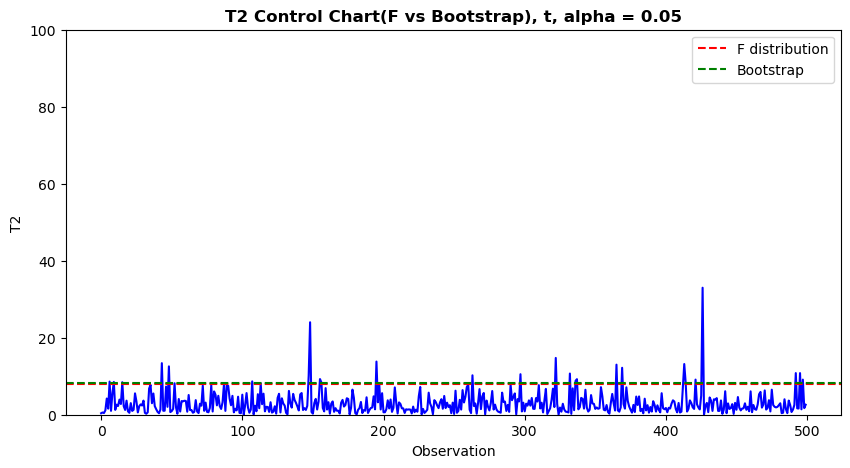

---------- False alarm with F distribution ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.056
---------- False alarm with Bootstrap ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.052


In [37]:
# t distribution T2 control chart
alpha = 0.05
t2_control_limit(data=data_multi_t, alpha=alpha, data_dist_name='t')